In [1]:
!pip install pandas scikit-learn

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from IPython.display import clear_output

# Funciones

In [3]:
def readFile(path):
    """
    Lee un archivo CSV y lo convierte en un DataFrame de pandas.
    :param path: Ruta del archivo CSV.
    :return: DataFrame con los datos leídos del CSV.
    """
    # Leer el archivo CSV
    data = pd.read_csv(path, header=None)

    # Asumimos que la última columna es la etiqueta
    data.columns = [f'feature_{i}' for i in range(data.shape[1] - 1)] + ['label']

    return data

def normalize(data):
    """
    Normaliza los datos del DataFrame. Convierte las características en un vector y aplica normalización estándar.
    :param data: DataFrame con los datos a normalizar.
    :return: DataFrame con datos normalizados.
    """
    # Asegurarse de que todos los datos sean numéricos
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Eliminar filas con valores NaN
    data = data.dropna()

    # Separar características y etiqueta
    X = data.drop(columns=['label'])
    y = data['label']

    # Normalizar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Crear un nuevo DataFrame con características normalizadas
    normalized_data = pd.DataFrame(X_scaled, columns=X.columns)
    normalized_data['label'] = y.values

    return normalized_data

In [4]:
def train(data_normalized, nIter, learningRate, lambda_reg):
    """
    Entrena un modelo RandomForestClassifier con los datos normalizados.
    :param data_normalized: DataFrame con los datos normalizados.
    :param nIter: Número de árboles en el bosque.
    :param learningRate: Tasa de aprendizaje (no usado en RandomForest, aquí por si se necesita en el futuro).
    :param lambda_reg: Tasa de regularización (no usado en RandomForest, aquí por si se necesita en el futuro).
    :return: El modelo entrenado y el DataFrame de prueba.
    """
    # Separar características y etiqueta
    X = data_normalized.drop(columns=['label'])
    y = data_normalized['label']

    # Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Crear el clasificador RandomForest
    model = RandomForestClassifier(
        n_estimators=nIter,  # Número de árboles en el bosque
        max_depth=5,  # Profundidad máxima de los árboles
        random_state=42
    )

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Crear un DataFrame de prueba
    test_df = pd.DataFrame(X_test, columns=X.columns)
    test_df['label'] = y_test.values

    return model, X_test, y_test, test_df

In [23]:
def accuracy(X_test, y_test, model):
    """
    Calcular la precisión del modelo en el conjunto de prueba.
    """
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Ejecucion lectura datos


In [6]:
# Medir el tiempo de inicio
start_time = time.time()

In [7]:
col_names = [
    'pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport',
    'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev',
    'smac', 'dmac', 'sum', 'min', 'max', 'soui', 'doui', 'sco', 'dco',
    'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
    'attack', 'category', 'subcategory'
]

# Definir los tipos de datos correspondientes a cada columna
col_types = {
    'pkSeqID': int, 'stime': float, 'flgs': str, 'proto': str,
    'saddr': str, 'sport': float, 'daddr': str, 'dport': float, 'pkts': int, 'bytes': int,
    'state': str,'ltime': float, 'seq': int, 'dur': float, 'mean': float, 'stddev': float, 'smac': str,
    'dmac': str, 'sum': float, 'min': float, 'max': float, 'soui': float, 'doui': float,
    'sco': float, 'dco': str, 'spkts': str, 'dpkts': str, 'sbytes': str, 'dbytes': str,
    'rate': str, 'srate': str, 'drate': str, 'attack': str, 'category': str, 'subcategory': str
}

# Definir las URLs de los archivos CSV
url_base = 'https://raw.githubusercontent.com/Meusz/FinOps/main/data/data_'
urls = [url_base + str(i) + '.csv' for i in range(1, 19)]

# Inicializar un DataFrame vacío
df_combinado = pd.DataFrame(columns=col_names)
# Convertir tipos de columnas según el diccionario col_types
df_combinado = df_combinado.astype(col_types)


# Descargar y combinar los archivos CSV en un DataFrame

for url in urls:
    clear_output()
    print(f"Ultimo URL leido:{url}")

    df = pd.read_csv(url,names=col_names,header=0)
    # Convertir 'sport' y 'dport' a tipo numérico, ignorando los errores
    df['sport'] = pd.to_numeric(df['sport'], errors='coerce')
    df['dport'] = pd.to_numeric(df['dport'], errors='coerce')

    # Llenar NaN en las columnas con un valor predeterminado, por ejemplo 0
    df['pkts'].fillna(0, inplace=True)
    df['bytes'].fillna(0, inplace=True)
    df['seq'].fillna(0, inplace=True)

    # Convertir las columnas a tipo int después de manejar NaN
    df['pkts'] = df['pkts'].astype(int)
    df['bytes'] = df['bytes'].astype(int)
    df['seq'] = df['seq'].astype(int)

    df=df.astype(col_types)
    # Combinar los DataFrames
    df_combinado = pd.concat([df_combinado, df])
    del df


# Mostrar el DataFrame combinado
clear_output()

df_combinado.drop(df_combinado[df_combinado['category'] == 'nan'].index, inplace=True)

#["flgs", "proto", "pkts", "bytes", "dur", "mean", "stddev", "sum", "min", "max", "rate", "category"]

df_combinado.loc[df_combinado["proto"] == "tcp", "proto"] = 0
df_combinado.loc[df_combinado["proto"] == "udp", "proto"] = 1
df_combinado.loc[df_combinado["proto"] == "icmp", "proto"] = 2
df_combinado.loc[df_combinado["proto"] == "arp", "proto"] = 3
df_combinado.loc[df_combinado["proto"] == "ipv6-icmp", "proto"] = 4
df_combinado.loc[df_combinado["proto"] == "igmp", "proto"] = 4
df_combinado.loc[df_combinado["proto"] == "rarp", "proto"] = 4



df_combinado.loc[df_combinado["category"] == "Reconnaissance", "category"] = 0
df_combinado.loc[df_combinado["category"] == "DoS", "category"] = 1
df_combinado.loc[df_combinado["category"] == "Normal", "category"] = 2
df_combinado.loc[df_combinado["category"] == "Theft", "category"] = 3
df_combinado.loc[df_combinado["category"] == "Reconnai", "category"] = 4

df_combinado['category'] = df_combinado['category'].astype(int)
df_combinado['proto'] = df_combinado['proto'].astype(int)




df_combinado = df_combinado.dropna(subset=["flgs", "proto", "pkts", "bytes", "dur", "mean", "stddev", "sum", "min", "max", "rate", "category"])
#df_combinado.drop(df_combinado[df_combinado['daddr'] == 'nan'].index, inplace=True)

df_combinado

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory
0,1,1.526344e+09,e,3,192.168.100.1,NaN,192.168.100.3,NaN,4,240,...,2,2,120,120,0.002508,0.000836,0.000836,0,2,Normal
1,2,1.526344e+09,e,0,192.168.100.7,139.0,192.168.100.4,36390.0,10,680,...,5,5,350,330,0.00619,0.002751,0.002751,0,2,Normal
2,3,1.526344e+09,e,1,192.168.100.149,51838.0,27.124.125.250,123.0,2,180,...,1,1,90,90,20.59096,0.0,0.0,0,2,Normal
3,4,1.526344e+09,e,3,192.168.100.4,NaN,192.168.100.7,NaN,10,510,...,5,5,210,300,0.006189,0.002751,0.002751,0,2,Normal
4,5,1.526344e+09,e,1,192.168.100.27,58999.0,192.168.100.1,53.0,4,630,...,2,2,174,456,0.005264,0.001755,0.001755,0,2,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110023,1653909,1.526963e+09,e,0,192.168.100.149,41228.0,192.168.100.5,5060.0,2,120,...,1.0,1.0,60.0,60.0,300.300293,0.0,0.0,1.0,0,OS_Fingerprint
110024,1653910,1.526963e+09,e,0,192.168.100.149,41228.0,192.168.100.5,32769.0,2,120,...,1.0,1.0,60.0,60.0,295.246521,0.0,0.0,1.0,0,OS_Fingerprint
110025,1653911,1.526963e+09,e,0,192.168.100.149,41228.0,192.168.100.5,1233.0,2,120,...,1.0,1.0,60.0,60.0,292.312195,0.0,0.0,1.0,0,OS_Fingerprint
110026,1653912,1.526963e+09,e,0,192.168.100.149,41228.0,192.168.100.5,16992.0,2,120,...,1.0,1.0,60.0,60.0,283.848999,0.0,0.0,1.0,0,OS_Fingerprint


In [8]:
df_combinado['proto'] = df_combinado['proto'].astype(int)

In [9]:
# Se eliminan las columnas innecesarias del DataFrame
df_combinado=df_combinado.drop(columns = ['pkSeqID', 'stime', 'flgs', 'ltime', 'seq', 'smac',  'dmac', 'soui', 'doui', 'sco', 'dco', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'srate', 'drate', 'attack', 'subcategory'])

# Selecciona las columnas de tipo 'object' en el DataFrame  y devuelve sus nombres
print(df_combinado.select_dtypes(include=['object']).columns)

# Calcula la cantidad de valores NaN por columna en el DataFrame
print(df_combinado.isna().sum())


# Elimina las filas donde la columna 'sport' tiene valores NaN en el DataFrame

df_combinado = df_combinado.dropna(subset=['sport','proto'])

# Elimina las filas duplicadas
df_combinado.drop_duplicates(inplace = True)

# Elimina las columnas especificadas del DataFrame
df_combinado = df_combinado.drop(columns = ['saddr', 'daddr',  'state', 'sport', 'dport'])


# Guardar el DataFrame df_combinado en un archivo CSV
df_combinado.to_csv('botnet.csv', index=False)
print(df_combinado.head())
del df_combinado

Index(['saddr', 'daddr', 'state', 'rate'], dtype='object')
proto           0
saddr           0
sport       32601
daddr           0
dport       32602
pkts            0
bytes           0
state           0
dur             0
mean            0
stddev          0
sum             0
min             0
max             0
rate            0
category        0
dtype: int64
   proto  pkts  bytes          dur      mean    stddev       sum       min  \
1      0    10    680  1453.945923  0.000028  0.000008  0.000138  0.000022   
2      1     2    180     0.048565  0.048565  0.000000  0.048565  0.048565   
4      1     4    630   569.933960  0.098505  0.080150  0.197011  0.018356   
7      1     2    172     2.500101  0.000000  0.000000  0.000000  0.000000   
8      1     2    172     2.501101  0.000000  0.000000  0.000000  0.000000   

        max      rate  category  
1  0.000042   0.00619         2  
2  0.048565  20.59096         2  
4  0.178655  0.005264         2  
7  0.000000  0.399984         2  
8

In [10]:
# Extraer el archivo CSV del ZIP y cargarlo en un DataFrame
path = 'botnet.csv'
nIter = 5
learningRate = 0.1
lambda_reg = 0.1

In [11]:
# Medir el tiempo de finalización
end_time = time.time()
# Calcular y mostrar el tiempo de ejecución
execution_time = end_time - start_time
print(f'Tiempo de ejecución: {execution_time:.2f} segundos, {execution_time/60:.2f}  minutos')

Tiempo de ejecución: 82.59 segundos, 1.38  minutos


# Ejecucion entrenamiento RandomForest


In [12]:
# Medir el tiempo de inicio
start_time = time.time()

In [13]:
# Convertir el DataFrame de Spark a un RDD
data = readFile(path)

<ipython-input-3-72d40640196e>:8: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, header=None)


In [14]:
# Normalize the numeric RDD
data_normalized =normalize(data)

In [15]:
# Entrenar el modelo con RDDs
model, X_test, y_test, test_df = train(data_normalized, nIter, learningRate, lambda_reg)
y_pred = model.predict(X_test)

In [16]:
# Calcular la precisión
acc = accuracy(X_test, y_test, model)
print(f'Accuracy: {acc * 100:.2f}%')

Precisión: 1.00
Accuracy: 99.63%


In [17]:
# Calcular el F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # Cambia average a 'macro', 'micro' o 'weighted' para otros casos
print(f'F1 Score: {f1:.2f}')

# Calcular el MSE (Mean Squared Error) - Aunque MSE no es común para clasificación, se puede calcular para ver el error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Calcular R²
r2 = r2_score(y_test, y_pred)
print(f'R² (Coeficiente de Determinación): {r2:.2f}')

F1 Score: 1.00
Mean Squared Error (MSE): 0.01
R² (Coeficiente de Determinación): 0.88


In [18]:
# Medir el tiempo de finalización
end_time = time.time()
# Calcular y mostrar el tiempo de ejecución
execution_time = end_time - start_time
print(f'Tiempo de ejecución: {execution_time:.2f} segundos, {execution_time/60:.2f}  minutos')

Tiempo de ejecución: 18.32 segundos, 0.31  minutos


# Bootstrap Validation

## Funcion

In [19]:
def evaluate_model(test_df, model):
    """
    Evalúa el modelo usando varias métricas de rendimiento y muestra los resultados.
    :param test_df: DataFrame con los datos de prueba.
    :param model: Modelo entrenado.
    :return: Un diccionario con las métricas de evaluación.
    """
    # Separar características y etiqueta
    X_test = test_df.drop(columns=['label'])
    y_test = test_df['label']

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Imprimir los resultados
    print(f"Precisión: {accuracy:.2f}")
    print(f"Precisión ponderada: {precision:.2f}")
    print(f"Recall ponderado: {recall:.2f}")
    print(f"Puntuación F1: {f1:.2f}")

    # Retornar un diccionario con las métricas
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

## Ejecucion

In [28]:
# Medir el tiempo de inicio
start_time = time.time()

In [29]:
#definir cuantas bloques quiere dividir para cross-validation
iterations = 5
avg_acc = 0

In [30]:
for i in range(iterations):
    model, X_test, y_test, test_df = train(data_normalized, nIter, learningRate, lambda_reg)
    # Predecir las etiquetas en el conjunto de prueba
    acc = accuracy(X_test, y_test, model)
    avg_acc += acc
    print(f"Cross-Validation con clave:{i}, the acc:{acc}")
avg_acc = avg_acc/iterations
print("averge acc:" , avg_acc)

Cross-Validation con clave:0, the acc:0.9963413538854686
Cross-Validation con clave:1, the acc:0.9963413538854686
Cross-Validation con clave:2, the acc:0.9963413538854686
Cross-Validation con clave:3, the acc:0.9963413538854686
Cross-Validation con clave:4, the acc:0.9963413538854686
averge acc: 0.9963413538854686


In [31]:
# Medir el tiempo de finalización
end_time = time.time()
# Calcular y mostrar el tiempo de ejecución
execution_time = end_time - start_time
print(f'Tiempo de ejecución: {execution_time:.2f} segundos, {execution_time/60:.2f}  minutos')

Tiempo de ejecución: 68.84 segundos, 1.15  minutos


# Graficos para el informe

## Ejecucion

In [32]:
# Medir el tiempo de inicio
start_time = time.time()

In [33]:
labels = [0, 1, 2]  # Cambia según las etiquetas en tu dataset
# Obtener características y etiquetas de prueba
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# Hacer predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Gráficos para el informe
feature_names = X_test.columns

Gráfico de Importancia de las Características

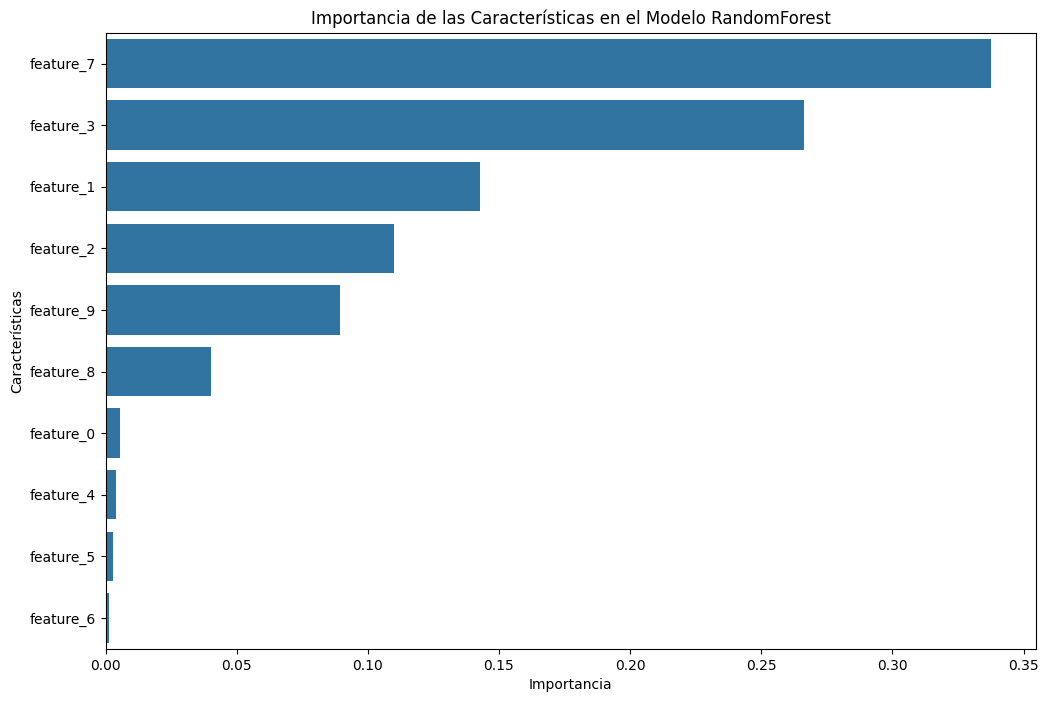

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importances(model, feature_names):
    """
    Grafica la importancia de las características del modelo RandomForestClassifier.
    :param model: Modelo RandomForestClassifier entrenado.
    :param feature_names: Nombres de las características.
    """
    # Obtener la importancia de las características del modelo
    importances = model.feature_importances_

    # Crear un DataFrame con las características y sus importancias
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Graficar la importancia de las características
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title('Importancia de las Características en el Modelo RandomForest')
    plt.xlabel('Importancia')
    plt.ylabel('Características')
    plt.show()

plot_feature_importances(model, feature_names)


Matriz de Confusión

<Figure size 1000x700 with 0 Axes>

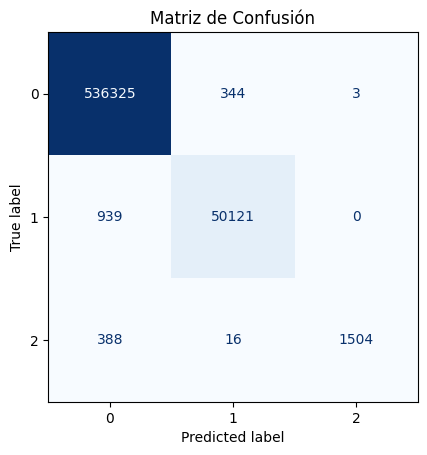

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Grafica la matriz de confusión.
    :param y_true: Etiquetas verdaderas.
    :param y_pred: Etiquetas predichas.
    :param labels: Etiquetas de las clases.
    """
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Crear una visualización de la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 7))
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(y_test, y_pred, labels)


 Curva ROC y AUC

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


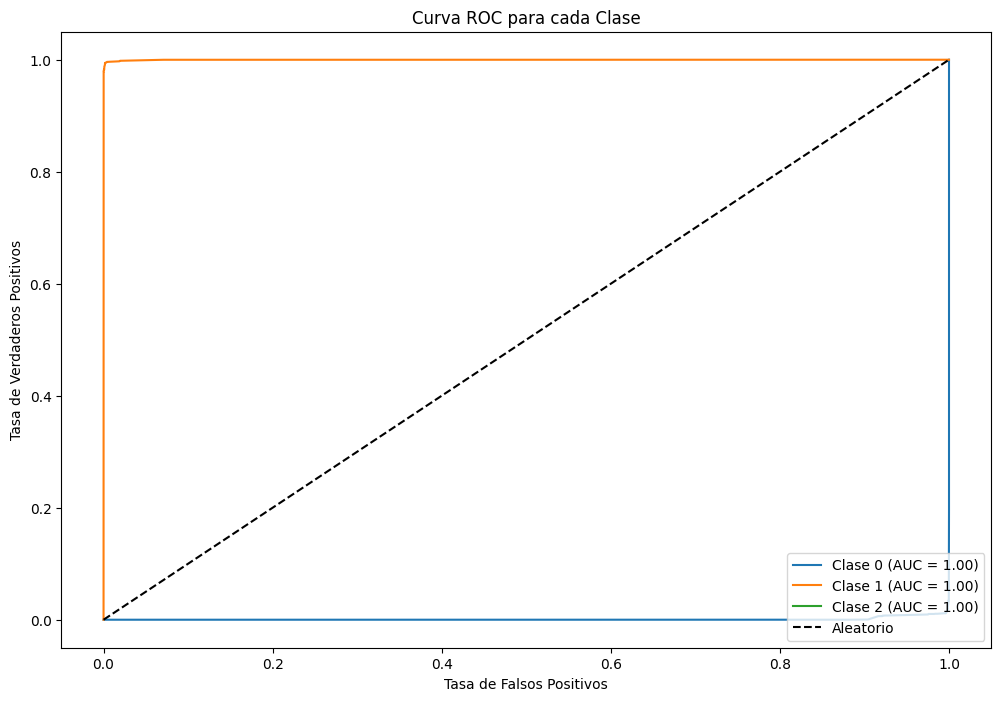

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_proba, labels):
    """
    Grafica la curva ROC para cada clase.
    :param y_true: Etiquetas verdaderas.
    :param y_proba: Probabilidades predichas por el modelo.
    :param labels: Etiquetas de las clases.
    """
    plt.figure(figsize=(12, 8))

    for i, label in enumerate(labels):
        # Calcular la curva ROC
        fpr, tpr, _ = roc_curve(y_true == label, y_proba[:, i], pos_label=label)
        auc = roc_auc_score(y_true == label, y_proba[:, i])

        # Graficar la curva ROC
        plt.plot(fpr, tpr, label=f'Clase {label} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.title('Curva ROC para cada Clase')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, y_proba, labels)


Curvas de Aprendizaje

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


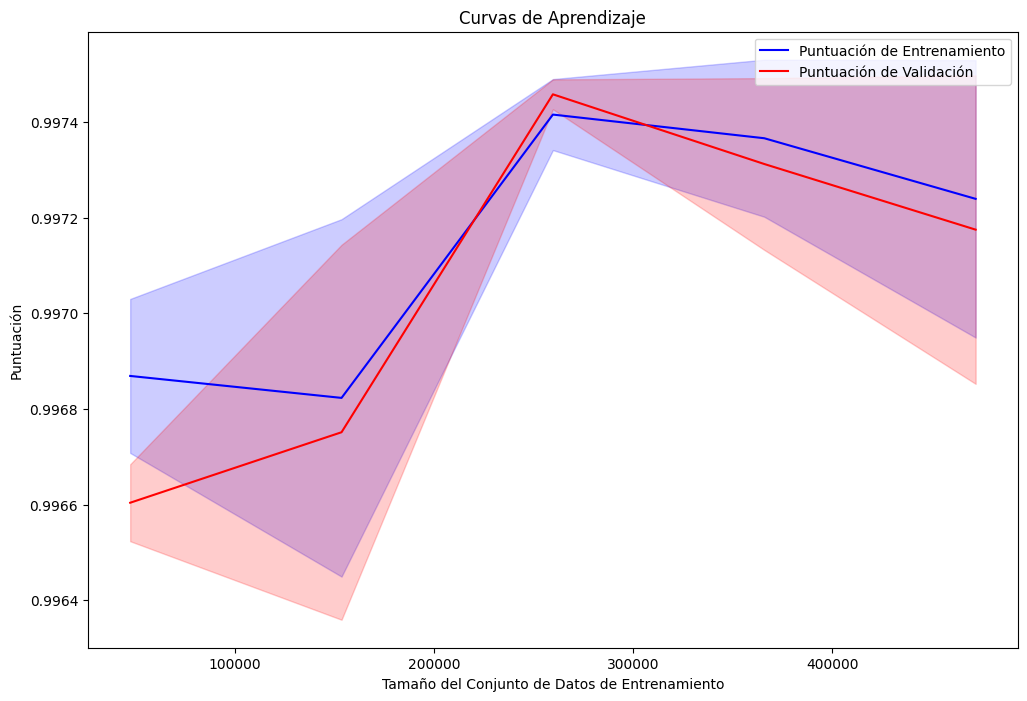

In [37]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y):
    """
    Grafica las curvas de aprendizaje para el modelo.
    :param model: Modelo RandomForestClassifier entrenado.
    :param X: Datos de características.
    :param y: Etiquetas.
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1)

    # Calcular el promedio y desviación estándar de los scores
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes, train_mean, label='Puntuación de Entrenamiento', color='blue')
    plt.plot(train_sizes, test_mean, label='Puntuación de Validación', color='red')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)
    plt.title('Curvas de Aprendizaje')
    plt.xlabel('Tamaño del Conjunto de Datos de Entrenamiento')
    plt.ylabel('Puntuación')
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(model, X_test, y_test)

Distribución de las Predicciones

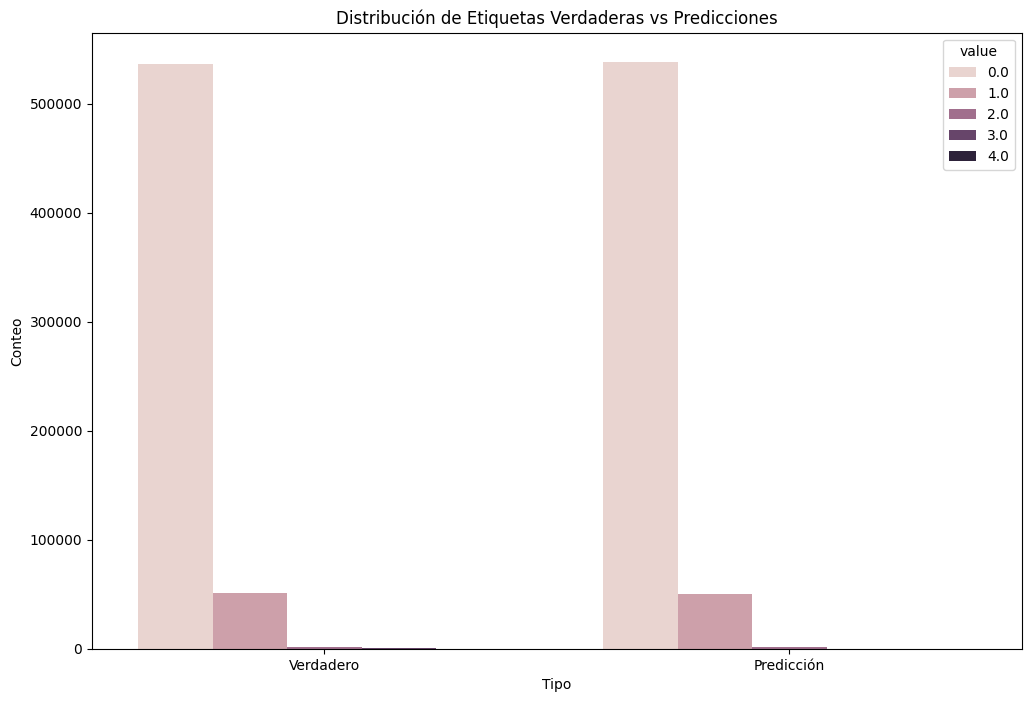

In [38]:
def plot_prediction_distribution(y_true, y_pred):
    """
    Grafica la distribución de las etiquetas verdaderas y las predicciones del modelo.
    :param y_true: Etiquetas verdaderas.
    :param y_pred: Etiquetas predichas.
    """
    plt.figure(figsize=(12, 8))

    # Crear DataFrame para la visualización
    df = pd.DataFrame({'Verdadero': y_true, 'Predicción': y_pred})

    # Crear una gráfica de conteo
    sns.countplot(data=df.melt(value_vars=['Verdadero', 'Predicción']), x='variable', hue='value')
    plt.title('Distribución de Etiquetas Verdaderas vs Predicciones')
    plt.xlabel('Tipo')
    plt.ylabel('Conteo')
    plt.show()

plot_prediction_distribution(y_test, y_pred)


Ejecucion

In [39]:
# Medir el tiempo de finalización
end_time = time.time()
# Calcular y mostrar el tiempo de ejecución
execution_time = end_time - start_time
print(f'Tiempo de ejecución: {execution_time:.2f} segundos, {execution_time/60:.2f}  minutos')

Tiempo de ejecución: 57.65 segundos, 0.96  minutos


# Analizar componentes

In [40]:
import psutil
import subprocess
import os

# Obtener información del procesador
cpu_info = os.popen("cat /proc/cpuinfo | grep 'model name' | uniq").read().strip()
print(f'Modelo de procesador: {cpu_info}')

# Número de procesadores físicos
num_processors = psutil.cpu_count(logical=False)
print(f'Número de procesadores físicos: {num_processors}')

# Número de vCores
num_vcores = psutil.cpu_count(logical=True)
print(f'Número de vCores (procesadores lógicos): {num_vcores}')

# Capacidad de memoria
mem = psutil.virtual_memory()
total_memory_gb = mem.total / (1024 ** 3)  # Convertir bytes a GB
available_memory_gb = mem.available / (1024 ** 3)  # Convertir bytes a GB
print(f'Capacidad total de memoria RAM: {total_memory_gb:.2f} GB')
print(f'Memoria RAM disponible: {available_memory_gb:.2f} GB')

# Información del disco duro
disk_usage = psutil.disk_usage('/')
total_disk_gb = disk_usage.total / (1024 ** 3)  # Convertir bytes a GB
used_disk_gb = disk_usage.used / (1024 ** 3)    # Convertir bytes a GB
free_disk_gb = disk_usage.free / (1024 ** 3)    # Convertir bytes a GB
print(f'Capacidad total del disco duro: {total_disk_gb:.2f} GB')
print(f'Espacio utilizado del disco duro: {used_disk_gb:.2f} GB')
print(f'Espacio libre del disco duro: {free_disk_gb:.2f} GB')

# Tipo de disco duro
disk_info = os.popen("lsblk -o NAME,ROTA,TYPE,SIZE | grep '^sda'").read().strip()
print(f'Tipo de disco duro: {disk_info}')

# Información del nodo
node_info = os.uname()
print(f'Información del nodo: {node_info}')

# Información detallada del sistema
print(f'Información detallada del sistema:')
print(f'Sistema: {node_info.sysname}')
print(f'Nombre del nodo: {node_info.nodename}')
print(f'Release: {node_info.release}')
print(f'Versión: {node_info.version}')
print(f'Máquina: {node_info.machine}')

# Obtener información de la GPU
try:
    gpu_info = subprocess.check_output("nvidia-smi --query-gpu=name --format=csv,noheader", shell=True).decode('utf-8').strip()
    print(f'Modelo de GPU: {gpu_info}')
except subprocess.CalledProcessError:
    print('No se detectó GPU o NVIDIA-SMI no está instalado.')


Modelo de procesador: model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
Número de procesadores físicos: 1
Número de vCores (procesadores lógicos): 2
Capacidad total de memoria RAM: 12.67 GB
Memoria RAM disponible: 8.04 GB
Capacidad total del disco duro: 107.72 GB
Espacio utilizado del disco duro: 27.56 GB
Espacio libre del disco duro: 80.14 GB
Tipo de disco duro: sda        0 disk   75G
Información del nodo: posix.uname_result(sysname='Linux', nodename='09dd74842020', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024', machine='x86_64')
Información detallada del sistema:
Sistema: Linux
Nombre del nodo: 09dd74842020
Release: 6.1.85+
Versión: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Máquina: x86_64
No se detectó GPU o NVIDIA-SMI no está instalado.
